In [67]:
# Parameters
top_folder = "../data/top_collections"


In [68]:
%load_ext autoreload
%autoreload 2


import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(12,9)})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
df_t = pd.read_parquet(os.path.join(top_folder, 'asset_traits.parquet'), engine='pyarrow')
df_s = pd.read_parquet(os.path.join(top_folder, 'sales.parquet'), engine='pyarrow')
df_a = pd.read_parquet(os.path.join(top_folder, 'assets.parquet'), engine='pyarrow')

## Raw prices

<AxesSubplot:xlabel='timestamp', ylabel='price_eth'>

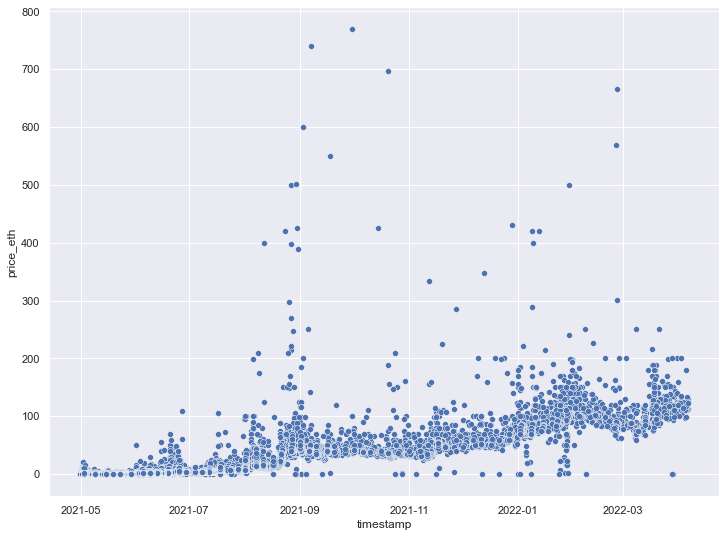

In [70]:
sns.scatterplot(data=df_s, x='timestamp', y='price_eth')

In [71]:
df_s = df_s.sort_values('timestamp')

windows = [10, 25, 50, 100, 200, 500]

for window in windows:
    df_s[f'price_eth_trend_{window}'] = df_s['price_eth'].rolling(window, center=False) \
        .quantile(0.5).fillna(method='backfill').fillna(method='pad')
    df_s[f'price_eth_floor_{window}'] = df_s['price_eth'].rolling(window, center=True) \
        .quantile(0.05).fillna(method='backfill').fillna(method='pad')
    df_s[f'price_eth_ceiling_{window}'] = df_s['price_eth'].rolling(window, center=True) \
        .quantile(0.95).fillna(method='backfill').fillna(method='pad')
    df_s[f'price_eth_std_{window}'] = df_s['price_eth'].rolling(window, center=True) \
        .std().fillna(method='backfill').fillna(method='pad')

    df_s[f'price_eth_int_{window}'] = df_s[f'price_eth_ceiling_{window}'] - df_s[f'price_eth_floor_{window}']

    df_s[f'price_eth_scaled_{window}'] = df_s['price_eth'] / df_s[f'price_eth_trend_{window}'] * df_s[f'price_eth_trend_{window}'].iloc[-1]

df_s.to_parquet(os.path.join(top_folder, 'sales_with_trend.parquet'))

## Rolling median with different window size

Window is left of the actual value. Thus it is not forward looking.

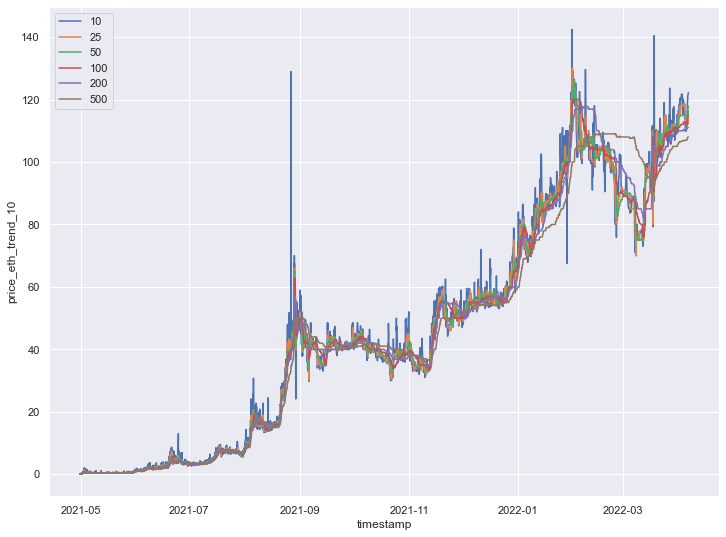

In [72]:
df_s2 = df_s.drop_duplicates(subset='timestamp').reset_index(drop=True).copy()

for window in windows:
    ax = sns.lineplot(data=df_s2, x='timestamp', y=f'price_eth_trend_{window}')

plt.legend(windows)

## Rolling median with different window size (log scale)

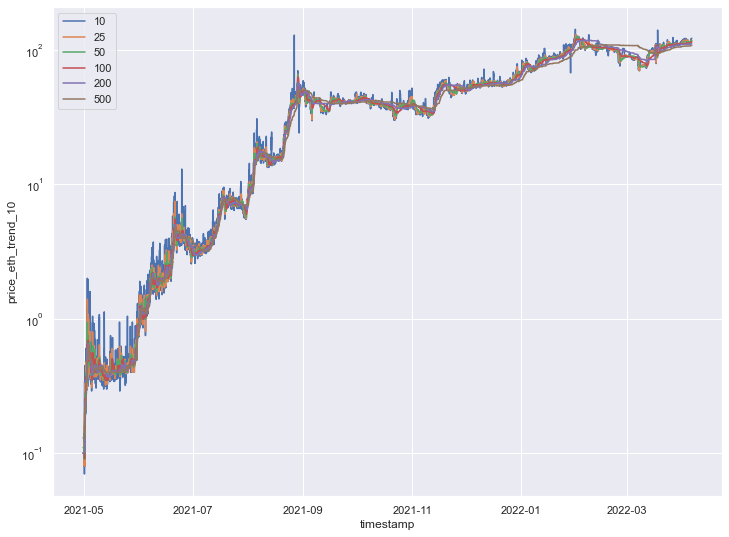

In [73]:
df_s2 = df_s.drop_duplicates(subset='timestamp').reset_index(drop=True).copy()

for window in windows:
    ax = sns.lineplot(data=df_s2, x='timestamp', y=f'price_eth_trend_{window}')
ax.set(yscale="log")

plt.legend(windows)

## Rolling median with different window size (log scale / Zoom July - August)

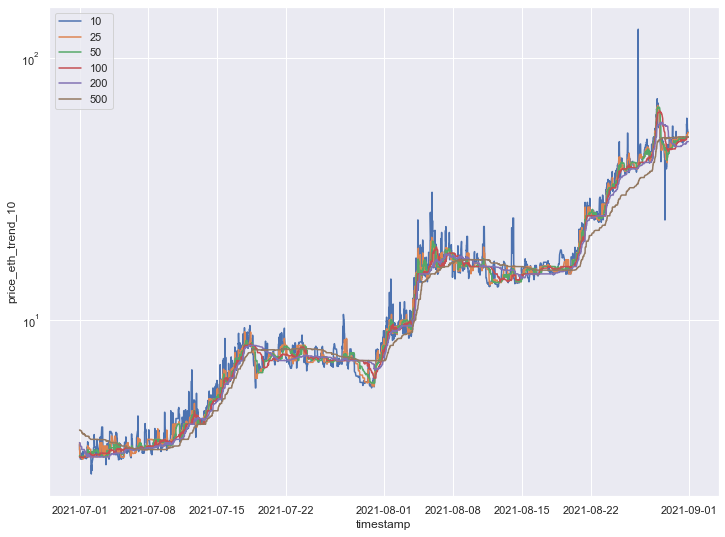

In [74]:
df_s2 = df_s.drop_duplicates(subset='timestamp').reset_index(drop=True).copy()


w = ((df_s2['timestamp'] > '2021-07-01') &
(df_s2['timestamp'] < '2021-09-01')) 


for window in windows:
    ax = sns.lineplot(data=df_s2[w], x='timestamp', y=f'price_eth_trend_{window}')
ax.set(yscale="log")

plt.legend(windows)

# Rolling standart deviation

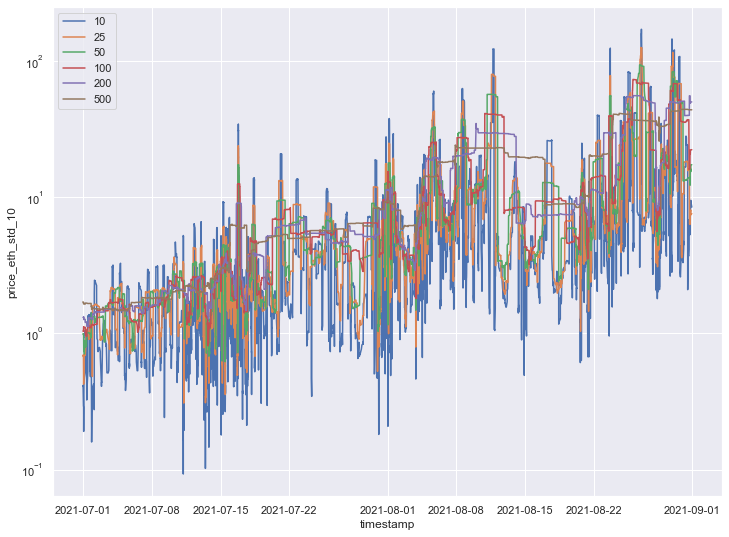

In [75]:
df_s2 = df_s.drop_duplicates(subset='timestamp').reset_index(drop=True).copy()


w = ((df_s2['timestamp'] > '2021-07-01') &
(df_s2['timestamp'] < '2021-09-01')) 


for window in windows:
    ax = sns.lineplot(data=df_s2[w], x='timestamp', y=f'price_eth_std_{window}')
ax.set(yscale="log")

plt.legend(windows)

[None]

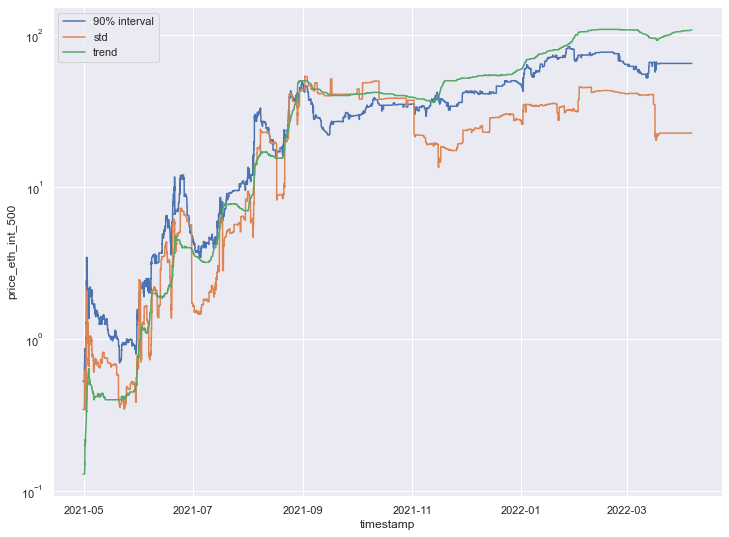

In [76]:
df_s2 = df_s.drop_duplicates(subset='timestamp').reset_index(drop=True).copy()


ax = sns.lineplot(data=df_s2, x='timestamp', y=f'price_eth_int_500')
ax = sns.lineplot(data=df_s2, x='timestamp', y=f'price_eth_std_500')
ax = sns.lineplot(data=df_s2, x='timestamp', y=f'price_eth_trend_500')
plt.legend(['90% interval', 'std', 'trend'])
ax.set(yscale="log")


# Raw data + rolling median + roliling lower 5%

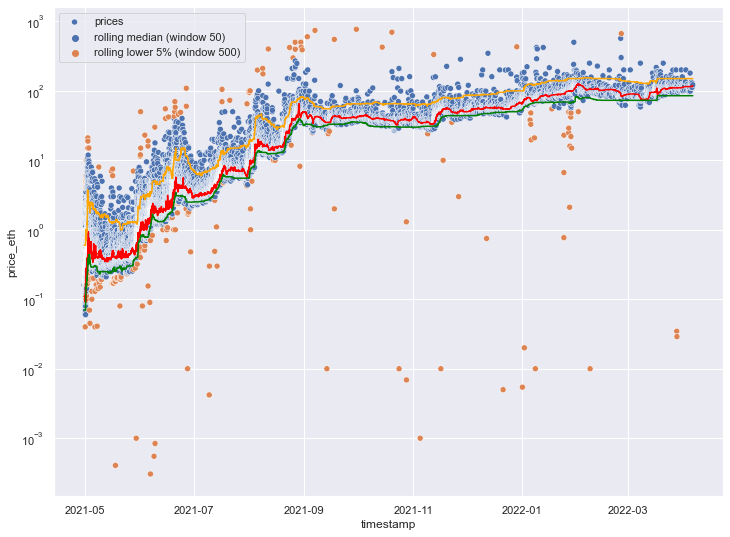

In [77]:
df_s2 = df_s.drop_duplicates(subset='timestamp').reset_index(drop=True).copy()

df_s2['outlier'] = ((df_s2['price_eth'] < 0.8 * df_s2['price_eth_floor_500']) | 
(df_s2['price_eth'] > 4 * df_s2['price_eth_ceiling_500']))

ax = sns.scatterplot(data=df_s2, x='timestamp', y='price_eth', hue='outlier')
ax = sns.lineplot(data=df_s2, x='timestamp', y=f'price_eth_trend_50', ax=ax, color='red')
ax = sns.lineplot(data=df_s2, x='timestamp', y=f'price_eth_floor_500', ax=ax, color='green')
ax = sns.lineplot(data=df_s2, x='timestamp', y=f'price_eth_ceiling_500', ax=ax, color='orange')
ax.set(yscale="log")

plt.legend(['prices', 'rolling median (window 50)', 'rolling lower 5% (window 500)'])

# Prices scaled by rolling median to the current price

[None]

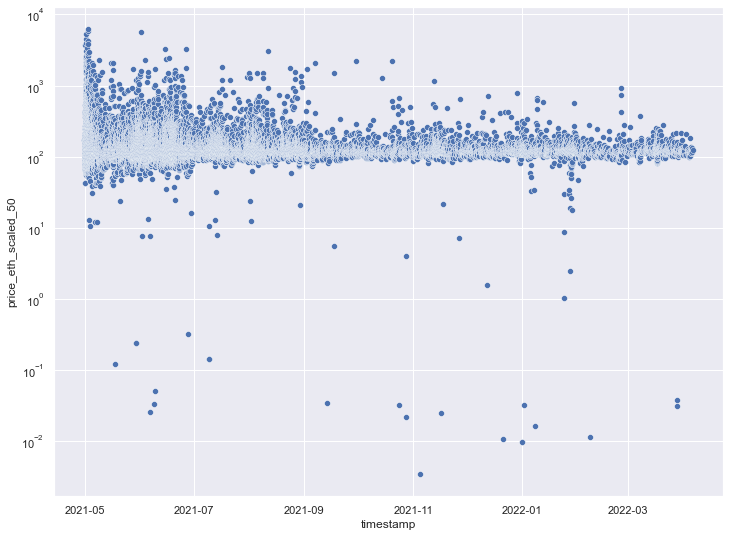

In [78]:
df_s2 = df_s.drop_duplicates(subset='timestamp').reset_index(drop=True).copy()

ax = sns.scatterplot(data=df_s2, x='timestamp', y='price_eth_scaled_50')
ax.set(yscale="log")

/Users/levinbrinkmann/repros/xai-nft/.venv/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


[(0.0, 500.0)]

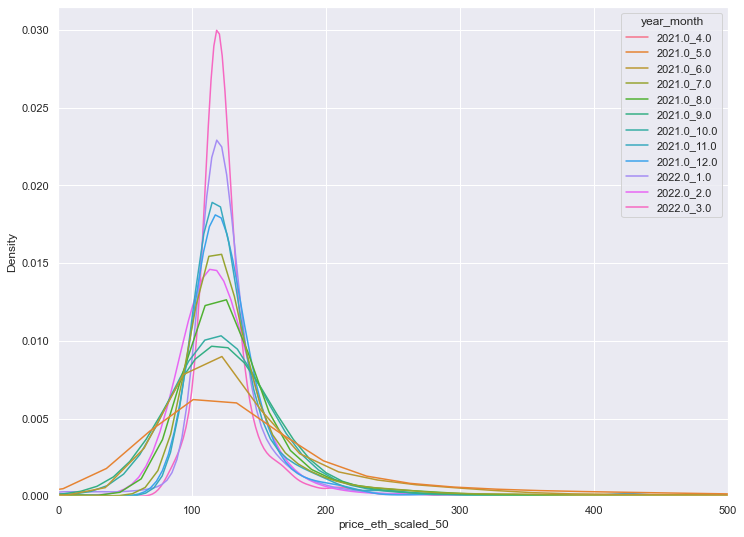

In [79]:
df_s2 = df_s.reset_index(drop=True).copy()

w = ((df_s2['timestamp'] > '2020-07-01') &
(df_s2['timestamp'] < '2022-04-01')) 

df_s2['year_month'] = df_s2['timestamp'].dt.year.astype(str) + "_" + df_s2['timestamp'].dt.month.astype(str)


ax = sns.kdeplot(data=df_s2[w], x='price_eth_scaled_50', hue='year_month', common_norm=False)

ax.set(xlim=[0,500])

[(0.0, 500.0)]

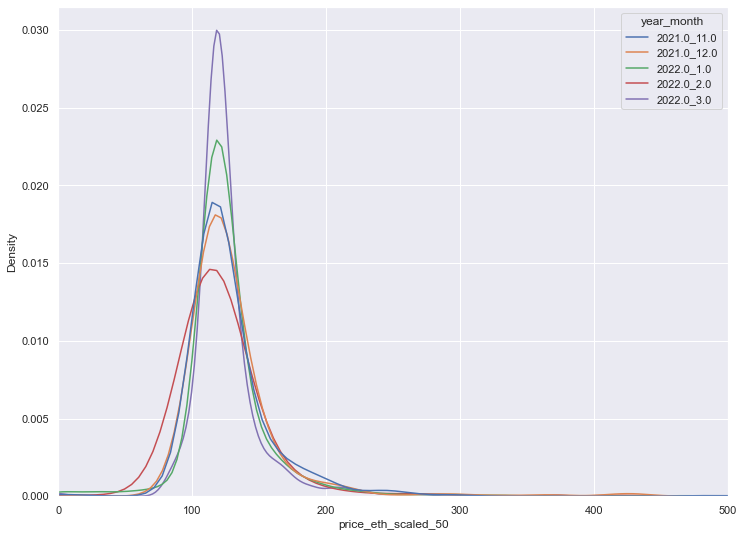

In [80]:
df_s2 = df_s.reset_index(drop=True).copy()

w = ((df_s2['timestamp'] > '2021-11-01') &
(df_s2['timestamp'] < '2022-04-01')) 

df_s2['year_month'] = df_s2['timestamp'].dt.year.astype(str) + "_" + df_s2['timestamp'].dt.month.astype(str)


ax = sns.kdeplot(data=df_s2[w], x='price_eth_scaled_50', hue='year_month', common_norm=False)

ax.set(xlim=[0,500])